In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
# import open3d as o3d  # 推荐安装 open3d 用于3D可视化

# 配置路径
DATA_ROOT = "/home/xzy/datasets/Rellis-3D" 
SEQ = "00004"
FRAME_ID = "000000"  # 示例帧

# 路径拼接 (根据 Rellis 目录结构)
# Rellis 通常结构: 00004/os1_cloud_node_kitti_bin/000000.bin
bin_path = os.path.join(DATA_ROOT, SEQ, 'os1_cloud_node_kitti_bin', f'{FRAME_ID}.bin')
img_path = os.path.join(DATA_ROOT, SEQ, 'pylon_camera_node', f'frame{FRAME_ID}-...jpg') # 需补全实际文件名

# 读取点云 (x, y, z, intensity)
points = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)
print(f"Point cloud shape: {points.shape}")

Point cloud shape: (131072, 4)


坐标轴位姿可视化：红绿蓝 x y z

In [ ]:
import open3d as o3d
import numpy as np

def parse_poses(filename):
    poses = []
    with open(filename, 'r') as f:
        for line in f:
            values = [float(v) for v in line.strip().split()]
            pose = np.eye(4)
            pose[:3, :4] = np.array(values).reshape(3, 4)
            poses.append(pose)
    return poses

pose_file = os.path.join(DATA_ROOT, SEQ, 'poses.txt')
poses = parse_poses(pose_file)

def visualize_trajectory_open3d(poses, visual_interval=10):
    """
    poses: 4x4 变换矩阵列表
    visual_interval: 每隔多少帧画一个坐标轴 (避免太密集)
    """
    geometries = []

    # 1. 创建轨迹线 (LineSet)
    # 提取所有平移向量 (位置)
    points = [p[:3, 3] for p in poses]
    
    # 定义线段连接关系: 0-1, 1-2, 2-3 ...
    lines = [[i, i+1] for i in range(len(points)-1)]
    
    # 创建 LineSet 对象
    line_set = o3d.geometry.LineSet()
    line_set.points = o3d.utility.Vector3dVector(points)
    line_set.lines = o3d.utility.Vector2iVector(lines)
    line_set.paint_uniform_color([0, 0, 0]) # 黑色轨迹线
    geometries.append(line_set)

    # 2. 创建坐标轴 (Coordinate Frames)
    # 红色=X(前), 绿色=Y(左), 蓝色=Z(上)
    for i in range(0, len(poses), visual_interval):
        # 创建一个小坐标轴，size 控制大小
        mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=2.0, origin=[0, 0, 0])
        
        # 将坐标轴变换到对应的位姿位置
        mesh_frame.transform(poses[i])
        geometries.append(mesh_frame)

    # 3. 启动可视化窗口 (类似 Pangolin)
    o3d.visualization.draw_geometries(geometries, 
                                      window_name="Trajectory Viewer",
                                      width=1024, height=768)

visualize_trajectory_open3d(poses, visual_interval=5)

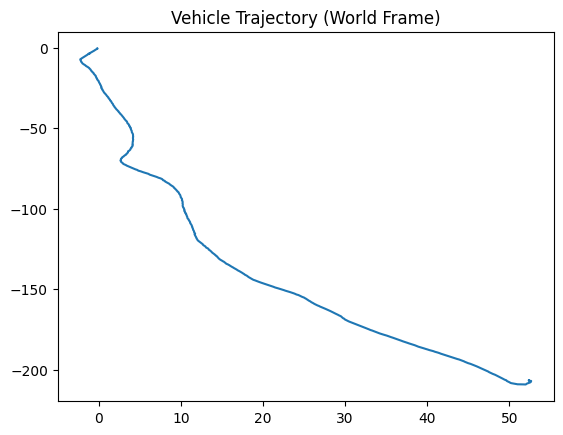

In [ ]:
def parse_poses(filename):
    poses = []
    with open(filename, 'r') as f:
        for line in f:
            values = [float(v) for v in line.strip().split()]
            pose = np.eye(4)
            pose[:3, :4] = np.array(values).reshape(3, 4)
            poses.append(pose)
    return poses

pose_file = os.path.join(DATA_ROOT, SEQ, 'poses.txt')
poses = parse_poses(pose_file)

# 提取 X, Y 轨迹进行绘制
traj_x = [p[0, 3] for p in poses]
traj_y = [p[1, 3] for p in poses]
plt.plot(traj_x, traj_y)
plt.title("Vehicle Trajectory (World Frame)")
plt.show()